# Exercise Series (Week 3/4)

The idea of this session is to use two Parallel-in-Time algorithms to solve general (non-linear) ODE system of the form :

$$
\frac{d{\bf u}}{dt} = {\bf f}({\bf u}, t),
$$

and focus on the **Lorentz system** introduced in S1. The two PinT methods that we implement and use are :

1. **Multiple-Shooting** from Chartier and Phillipe
2. **Parareal from Lions**, Maday and Turinici

## Multiple-Shooting

The update formula for Multiple-Shooting is

$$
{\bf u}_{n+1}^{k+1} = F_n({\bf u}_{n}^{k}, T_{n+1}) + \frac{\partial F_n}{\partial {\bf u}}({\bf u}_{n}^{k}, T_{n+1}) ({\bf u}_{n}^{k+1} - {\bf u}_{n}^{k})
$$

where $n$ is the time index, and $k$ is the iteration index.
We can identify two main components in this formula, that are :

- $F_n({\bf u}, t)$ : a vector valued function taking an initial solution ${\bf u}$ at $T_n$, and returning the solution at $t$, _i.e_ the function representing numerical time-integration between $T_n$ and $t$
- $V_n({\bf u}, t) := \frac{\partial F_n}{\partial {\bf u}}({\bf u}, t)$ : the Jacobian of $F_n$ evaluated with $({\bf u}, t)$.

So, in order to compute the Multiple-Shooting update, we need a way to compute numerically each term for any type of problem and time-integration method, then we can use it to solve a given problem.

1. [Implementation of Multiple-Shooting](#implementation-of-multiple-shooting)
2. [Application to the Lorentz System](#application-to-the-lorentz-system)
3. [Parallel-in-Time Error](#parallel-in-time-error)


### Implementation of Multiple-Shooting

The $F_n$ function is our time-integration method used to solve the non-linear system of ODE. For instance, we can use the Forward Euler time-stepping method already implemented for the first series.

Now in order to compute the $V_n({\bf u}, t)$, we use a **numerical propagation of the Jacobian** using the same time-integration method as $F_n$, that is Forward Euler.
To idea is as follow : let note $F({\bf u}) := F_n({\bf u}, t)$ for one given time-slice, and write its step-by-step computation using $M$ time-steps :

$$
\begin{array}{rcll}
    \displaystyle\frac{F_{m+1}({\bf u}) - F_{m}({\bf u})}{\Delta{t}}&=&{\bf f}(F_{m}({\bf u}), t_m) \quad\text{for} &m = 0, 1, \dots, M-1,\\
    F_{0}({\bf u})&=&{\bf u}.
\end{array}
$$

We can see that $F_{m}({\bf u})$ correspond to the successive solution of the propagator over the whole time-slice, and the final value used by Multiple-Shooting is simply $F_{M}({\bf u})$.
Now if we derivate this expression with respect to ${\bf u}$, then we get :

$$
\begin{array}{rcll}
    \displaystyle\frac{V_{m+1} - V_{m}}{\Delta{t}}&=&J_{\bf f}(F_{m}({\bf u}), t_m)V_{m} \quad\text{for} &m = 0, 1, \dots, M-1,\\
    V_{0}&=&I,
\end{array}
$$

where $V_{m}$ is the short notation for the successive Jacobian of $F$ over the whole time-slice, and in particular we have 
$V_n({\bf u}, t) = V_{M}$.
Hence if we propagate simultaneously both the solution $F_{m}$ and the Jacobian $V_{m}$ over the whole time slice, then we can get 
the $F_n({\bf u}, t)$ and $V_n({\bf u}, t)$ terms required to compute the Multiple-Shooting update.

So considering that we know the Jacobian function of the ODE right hand side ${\bf f}$, we define a Forward Euler propagator for the coupled system ($F_n({\bf u}, t)$ and $V_n({\bf u}, t)$) :

In [1]:
import numpy as np
from lorenz import forwardEuler

def coupledForwardEuler(f, jac, t0, t1, u0, nStep):
    s = np.size(u0)
    u0All = np.vstack([u0, np.eye(s)]).ravel()

    def rhs(t, u):
        return np.vstack([f(t,u[:s]), jac(t, u[:s]) @ u[s:].reshape((s,s))]).ravel()

    _, uAll = forwardEuler(rhs, t0, t1, u0All, nStep)

    u, V = uAll[:s, -1], uAll[s:, -1].reshape((s,s))
    return u, V

Here `uAll` corresponds to the solution vector and the Jacobian combined into one big vector. The `rhs` function evaluate both the ODE right hand side and the jacobian of ${\bf f}$, and return a concatenated vector.

Now that we have that, we can implement the Multiple-Shooting method, that takes the following arguments :

- `prop` : the coupled propagator for the solution and Jacobian
- `T` : final simulation time
- `u0` : initial solution
- `N` : number of time slices
- `K` : number of iterations
- `uPred` : initial condition (prediction) for ${\bf u^0}$ 

In [2]:
def multipleShooting(prop, T, u0, N, K, uPred):
    t = np.linspace(0, T, N+1)
    u0 = np.asarray(u0)
    u = np.zeros((K+1, N+1, u0.size))
    
    # Initial guess
    u[0, :] = uPred

    # Iterations
    for k in range(K):
        u[k+1, 0] = u0
        for n in range(N):
            uF, V = prop(t[n], t[n+1], u[k, n])
            u[k+1, n+1] = uF + V @ (u[k+1, n] - u[k, n])
    
    return u

This function returns the solution at each iteration and time-slices interval, and we can use it to solve the Lorentz system with Multiple Shooting

### Application to the Lorentz System

We define our system parameters, RHS and Jacobian :

In [3]:
sigma = 10; rho = 28; beta=8/3

def rhsLorentz(t, u):
    x, y, z = u
    return np.array([sigma*(y-x), x*(rho-z)-y, x*y-beta*z])

def jacobianLorentz(t, u):
    x, y, z = u
    return np.array([
        [-sigma, sigma, 0.0  ],
        [rho-z , -1   , -x   ],
        [y     , x    , -beta]
    ])

Then we define our time interval decomposition :

In [4]:
T = 1.0
u0 = [20, 5, -5]
K = 4
N = 500         # 500 time slices

and compute a "coarse" initial guess using one time-step per time-slice :

In [5]:
_, uPred = forwardEuler(rhsLorentz, 0, T, u0, N)

and finally define our propagator using $10$ time steps per time-slices :

In [6]:
def prop(t0, t1, u0):
    return coupledForwardEuler(rhsLorentz, jacobianLorentz, t0, t1, u0, 10)

Everything is set now to solve the Lorentz system using Multiple-Shooting, and show the different iterations for $z(t)$ :

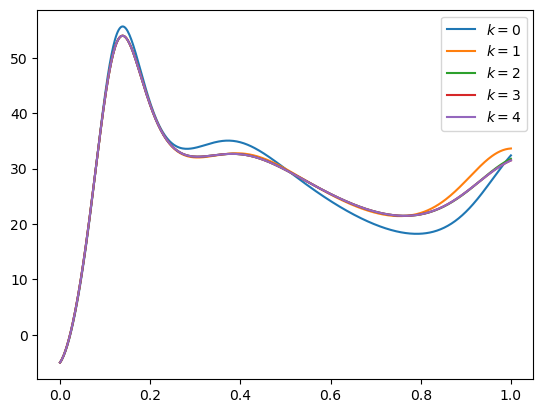

In [7]:
u = multipleShooting(prop, T, u0, N, K, uPred.T)

import matplotlib.pyplot as plt

t = np.linspace(0, T, N+1)
for k in range(K+1):
    plt.plot(t, u[k, :, 2], label=f'$k={k}$')
plt.legend()

We see that the error in the initial prediction, that is quickly corrected by the multiple shooting iterations that seems to converge already after $k=2$.

**To go further :** use the Multiple-Shooting method without using the Jacobian, but using a finite-difference approximation with evaluations of the ODE RHS.

### Parallel-in-Time Error

We can evaluate the error of Multiple-Shooting on the Lorentz system by looking at the error with the sequential solution computed with Forward Euler :

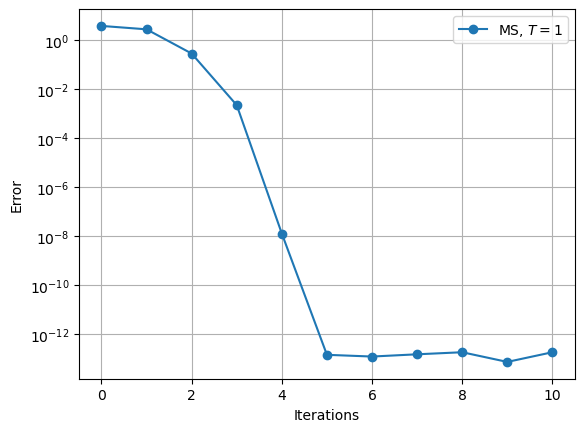

In [8]:
def plotMSError(T=1, N=500, M=10, K=10):
    _, uPred = forwardEuler(rhsLorentz, 0, T, u0, N)
    _, uRef = forwardEuler(rhsLorentz, 0, T, u0, N*M)
    uRef = uRef[:, ::M].T

    def prop(t0, t1, u0):
        return coupledForwardEuler(rhsLorentz, jacobianLorentz, t0, t1, u0, M)
    
    u = multipleShooting(prop, T, u0, N, K, uPred.T)
    
    err = np.max(np.abs(u-uRef), axis=-1)   # L_inf in space
    err = np.max(err, axis=-1)              # L_inf in time
    plt.semilogy(err, 'o-', label=f"MS, $T={T}$")
    plt.legend()
    plt.xlabel("Iterations")
    plt.ylabel("Error")
    plt.grid()

plotMSError()

We can observe that the convergence of the Multiple-Shooting method in 5 iterations up to machine precision, and we see in particular the super-linear convergence behavior already predicted by the theory.

Now, you may notice that we simulated (intentionally) for a small global time interval, such that the prediction error is not too large.
However if we change $T$ while keeping the same other settings, then convergence is not the same :

/tmp/ipykernel_12037/2151612017.py:14: RuntimeWarning: overflow encountered in matmul
  u[k+1, n+1] = uF + V @ (u[k+1, n] - u[k, n])
/tmp/ipykernel_12037/2151612017.py:14: RuntimeWarning: invalid value encountered in matmul
  u[k+1, n+1] = uF + V @ (u[k+1, n] - u[k, n])
/tmp/ipykernel_12037/1511925717.py:5: RuntimeWarning: overflow encountered in scalar multiply
  return np.array([sigma*(y-x), x*(rho-z)-y, x*y-beta*z])
/tmp/ipykernel_12037/3916789479.py:9: RuntimeWarning: overflow encountered in matmul
  return np.vstack([f(t,u[:s]), jac(t, u[:s]) @ u[s:].reshape((s,s))]).ravel()
/tmp/ipykernel_12037/1511925717.py:5: RuntimeWarning: invalid value encountered in scalar subtract
  return np.array([sigma*(y-x), x*(rho-z)-y, x*y-beta*z])
/tmp/ipykernel_12037/3916789479.py:9: RuntimeWarning: invalid value encountered in matmul
  return np.vstack([f(t,u[:s]), jac(t, u[:s]) @ u[s:].reshape((s,s))]).ravel()
/home/telu/Recherche/edu/pint-workshops/2023-06_IPH-Workshop/s3/lorenz.py:71: RuntimeWa

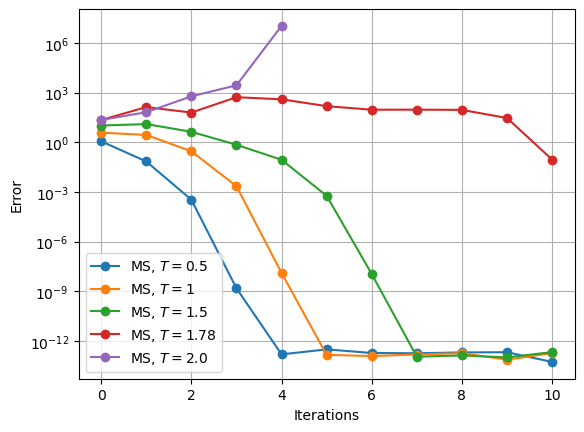

In [9]:
plotMSError(0.5)
plotMSError(1)
plotMSError(1.5)
plotMSError(1.78)
plotMSError(2.0)

As expected, using small time-slices length improve the accuracy of the initial prediction, along with the convergence speed of Multiple-Shooting. But as $T$ is increased, we see the convergence deteriorate, up to a threshold (around $T=1.78$) after which the algorithm completely diverge.

We can visualize this looking at the error over time for each iterations :

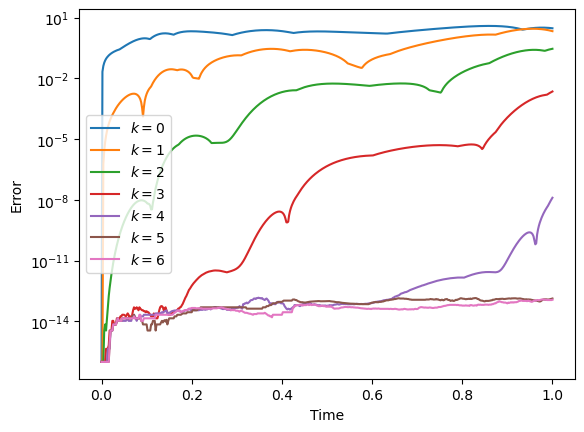

In [10]:
def plotErrorTime(T=1, N=500, M=10, K=6, nP=1):
    _, uPred = forwardEuler(rhsLorentz, 0, T, u0, N*nP)
    uPred = uPred[:, ::nP].T
    _, uRef = forwardEuler(rhsLorentz, 0, T, u0, N*M)
    uRef = uRef[:, ::M].T

    def prop(t0, t1, u0):
        return coupledForwardEuler(rhsLorentz, jacobianLorentz, t0, t1, u0, M)
    
    u = multipleShooting(prop, T, u0, N, K, uPred)
    
    err = np.max(np.abs(u-uRef), axis=-1)   # L_inf in space
    err = np.clip(err, 1e-16, 1e16)

    t = np.linspace(0, T, N+1)
    for k, e in enumerate(err):
        plt.semilogy(t, e, label=f"$k={k}$")

    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Error")

plotErrorTime()

There we can see the error decreasing with each iteration over the whole time interval. However, if we increase $T$ :

/tmp/ipykernel_12037/2151612017.py:14: RuntimeWarning: overflow encountered in matmul
  u[k+1, n+1] = uF + V @ (u[k+1, n] - u[k, n])
/tmp/ipykernel_12037/2151612017.py:14: RuntimeWarning: invalid value encountered in matmul
  u[k+1, n+1] = uF + V @ (u[k+1, n] - u[k, n])
/tmp/ipykernel_12037/1511925717.py:5: RuntimeWarning: overflow encountered in scalar multiply
  return np.array([sigma*(y-x), x*(rho-z)-y, x*y-beta*z])
/tmp/ipykernel_12037/3916789479.py:9: RuntimeWarning: overflow encountered in matmul
  return np.vstack([f(t,u[:s]), jac(t, u[:s]) @ u[s:].reshape((s,s))]).ravel()
/tmp/ipykernel_12037/1511925717.py:5: RuntimeWarning: invalid value encountered in scalar subtract
  return np.array([sigma*(y-x), x*(rho-z)-y, x*y-beta*z])
/tmp/ipykernel_12037/3916789479.py:9: RuntimeWarning: invalid value encountered in matmul
  return np.vstack([f(t,u[:s]), jac(t, u[:s]) @ u[s:].reshape((s,s))]).ravel()


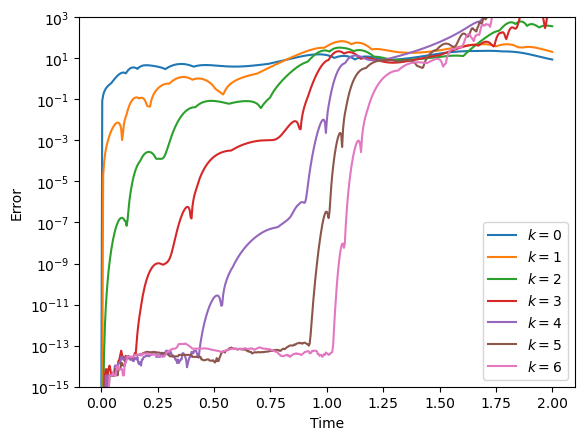

In [11]:

plotErrorTime(T=2)
plt.ylim(1e-15, 1e3);

There we can see a "wall" that prevent convergence after a given time, which is due to the chaotic nature of the Lorentz system and the limited accuracy of the time-integration. This cannot be prevented, even if we try to improve the accuracy of the propagator :

/tmp/ipykernel_12037/1511925717.py:5: RuntimeWarning: overflow encountered in scalar multiply
  return np.array([sigma*(y-x), x*(rho-z)-y, x*y-beta*z])
/tmp/ipykernel_12037/3916789479.py:9: RuntimeWarning: overflow encountered in matmul
  return np.vstack([f(t,u[:s]), jac(t, u[:s]) @ u[s:].reshape((s,s))]).ravel()
/tmp/ipykernel_12037/1511925717.py:5: RuntimeWarning: invalid value encountered in scalar subtract
  return np.array([sigma*(y-x), x*(rho-z)-y, x*y-beta*z])
/tmp/ipykernel_12037/3916789479.py:9: RuntimeWarning: invalid value encountered in matmul
  return np.vstack([f(t,u[:s]), jac(t, u[:s]) @ u[s:].reshape((s,s))]).ravel()


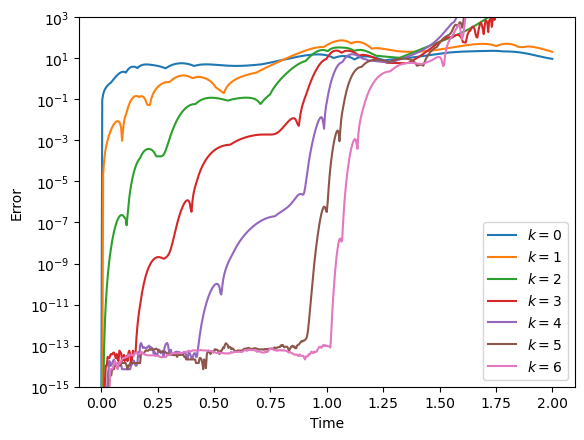

In [12]:
plotErrorTime(T=2, M=100)
plt.ylim(1e-15, 1e3);

The only solution to "push back" this "wall" is to improve the accuracy of the initial guess, for instance using here two Forward Euler steps per time-slice :

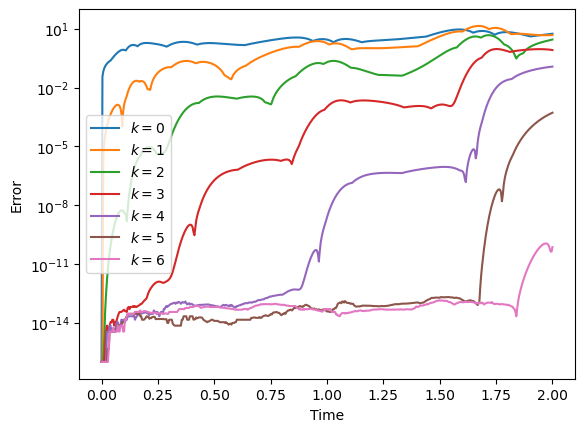

In [13]:
plotErrorTime(T=2, M=10, nP=2)

## Parareal

The update formula for Parareal is

$$
{\bf u}_{n+1}^{k+1} = F_n({\bf u}_{n}^{k}, T_{n+1}) + G_n({\bf u}_{n}^{k+1}, T_{n+1}) - G_n({\bf u}_{n}^{k}, T_{n+1}) 
$$

where $F_n$ corresponds to the fine propagator over the time-slice $[T_n, T_{n+1}]$ and $G_n$ corresponds to the coarse propagator on the same time-slice.
Furthermore, the initial guess is computed using a coarse initial propagation :

$$
{\bf u}_{n+1}^{0} = G_n({\bf u}_{n}^{0}, T_{n+1})
$$

We can see from this formula that Parareal approximate the Jacobian correction in Multiple Shooting 

$$
\frac{\partial F_n}{\partial {\bf u}}({\bf u}_{n}^{k}, T_{n+1}) ({\bf u}_{n}^{k+1} - {\bf u}_{n}^{k})
$$

by the coarse solver difference

$$
G_n({\bf u}_{n}^{k+1}, T_{n+1}) - G_n({\bf u}_{n}^{k}, T_{n+1})
$$

So in practice, it is easier to implement in comparison to Multiple-Shooting, as it does not requires the propagation of the Jacobian.

1. [Implementation of Parareal](#implementation-of-parareal)
2. [Parareal for Lorentz](#parareal-for-lorentz)
3. [Parareal Error](#parareal-error)

### Implementation of Parareal

As mentioned above, we need to provide for Parareal the coarse and fine propagator, together with the usual PinT parameters (number of time slices, iterations, ...).
Here is the implementation :

In [14]:
def parareal(F, G, T, u0, N, K):
    t = np.linspace(0, T, N+1)
    u0 = np.asarray(u0)
    u = np.zeros((K+1, N+1, u0.size))
    
    # Initial solution for each k
    u[:, 0] = u0

    # Initial coarse propagation
    for n in range(N):
        u[0, n+1] = G(t[n], t[n+1], u[0, n])

    # Iterations
    for k in range(K):
        for n in range(N):
            uF = F(t[n], t[n+1], u[k, n])
            uGk1 = G(t[n], t[n+1], u[k+1, n])
            uGk = G(t[n], t[n+1], u[k, n])
            u[k+1, n+1] = uF + uGk1 - uGk
    
    return u

This function returns the solution for each time-slices after each iteration. Of course, this implementation is just given as demonstration, and is not particularly optimized : indeed, the `uGk` term in each iteration does not have to be computed each time, since it can be obtained from either the initial coarse propagation, of from the previous iteration.

### Parareal for Lorentz

To apply Parareal on the Lorents system, we first define our fine and coarse propagators :

In [15]:
nF = 10
nG = 1

def propF(t0, t1, u0):
    _, u = forwardEuler(rhsLorentz, t0, t1, u0, nF)
    return u[:, -1].T

def propG(t0, t1, u0):
    _, u = forwardEuler(rhsLorentz, t0, t1, u0, nG)
    return u[:, -1].T

Now we are all set to use Parareal to solve the Lorentz system, using the same number of time-slices as before :

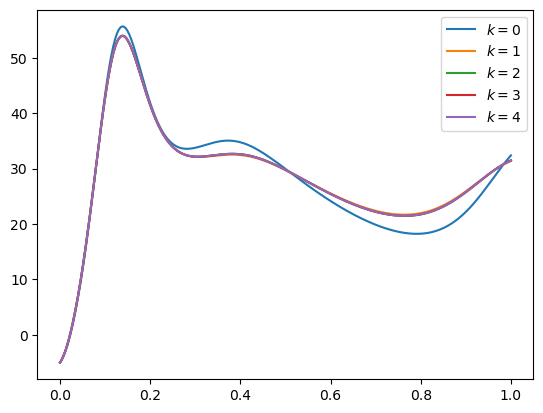

In [16]:
T = 1
N = 500

u = parareal(propF, propG, T, u0, N, K=4)

t = np.linspace(0, T, N+1)
for k in range(K+1):
    plt.plot(t, u[k, :, 2], label=f'$k={k}$')
plt.legend()

Similarly as for Multiple-Shooting, we can see that Parareal converges faster toward the final solution, and is already quite close to the converged solution after $k=2$ iterations. 

### Parareal Error

Now let us look at the error with respect to the fine solution over all iterations, and even compare it with the error of Multiple-Shooting :

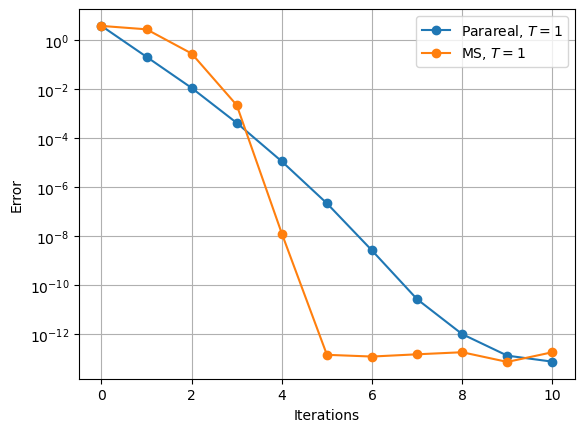

In [17]:
def plotPararealError(T=1, N=500, M=10, K=10, nF=10, nG=1):
    _, uRef = forwardEuler(rhsLorentz, 0, T, u0, N*nF)
    uRef = uRef[:, ::nF].T

    def propF(t0, t1, u0):
        _, u = forwardEuler(rhsLorentz, t0, t1, u0, nF)
        return u[:, -1].T

    def propG(t0, t1, u0):
        _, u = forwardEuler(rhsLorentz, t0, t1, u0, nG)
        return u[:, -1].T
    
    u = parareal(propF, propG, T, u0, N, K)
    
    err = np.max(np.abs(u-uRef), axis=-1)   # L_inf in space
    err = np.max(err, axis=-1)              # L_inf in time
    plt.semilogy(err, 'o-', label=f"Parareal, $T={T}$")
    plt.legend()
    plt.xlabel("Iterations")
    plt.ylabel("Error")

plotPararealError()
plotMSError()

Both algorithm start from the same initial guess, however Parareal converge faster for the first iteration, while Multiple-Shooting is advantaged later thanks to the rapid super-linear convergence. In particular, we can guess a light super-linear convergence for Parareal on the last iteration, even if in general the convergence looks linear.

Increasing $T$ does deteriorate the convergence of Parareal, but we don't see directly this rapid divergence for the first iterations as we saw before with Multiple-Shooting :

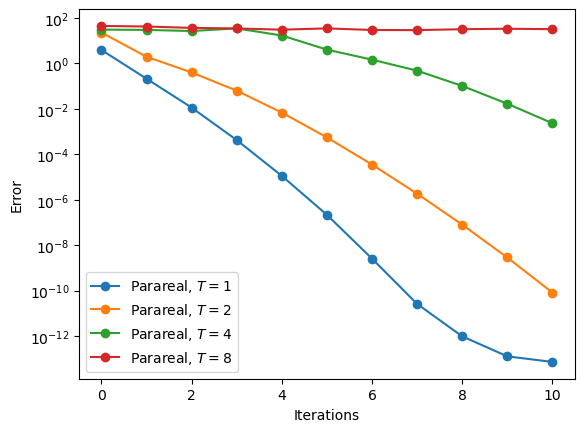

In [18]:
plotPararealError(T=1)
plotPararealError(T=2)
plotPararealError(T=4)
plotPararealError(T=8)

Now looking at the error over time :

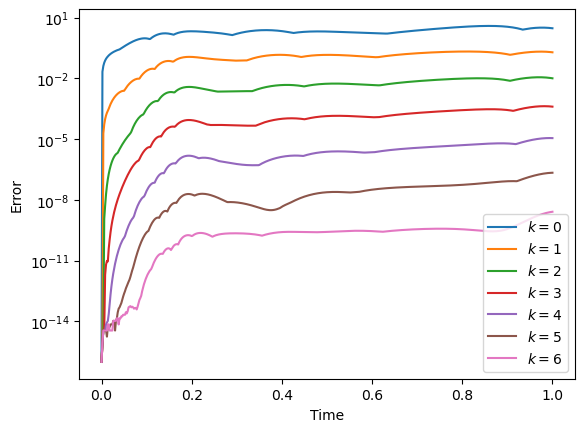

In [19]:
def plotErrorTime(T=1, N=500, M=10, K=6, nF=10, nG=1):
    _, uRef = forwardEuler(rhsLorentz, 0, T, u0, N*nF)
    uRef = uRef[:, ::nF].T

    def propF(t0, t1, u0):
        _, u = forwardEuler(rhsLorentz, t0, t1, u0, nF)
        return u[:, -1].T

    def propG(t0, t1, u0):
        _, u = forwardEuler(rhsLorentz, t0, t1, u0, nG)
        return u[:, -1].T
    
    u = parareal(propF, propG, T, u0, N, K)
    
    err = np.max(np.abs(u-uRef), axis=-1)   # L_inf in space
    err = np.clip(err, 1e-16, 1e16)

    t = np.linspace(0, T, N+1)
    for k, e in enumerate(err):
        plt.semilogy(t, e, label=f"$k={k}$")

    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Error")

plotErrorTime()

We can see that the convergence is uniform over the whole time interval. In particular, we don't see anymore this "wall" as for Multiple-Shooting. Even if we increase $T$, the convergence is slower, but the algorithm stays stable.

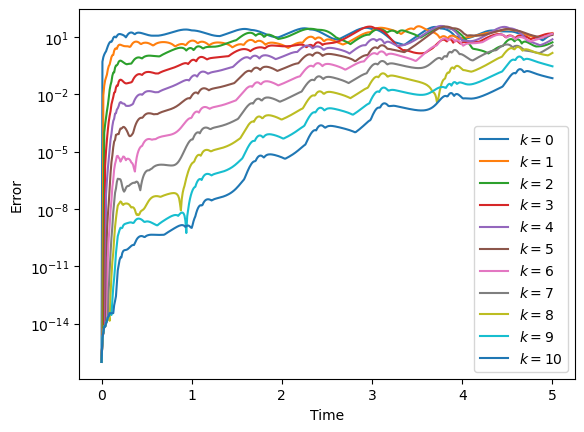

In [20]:
plotErrorTime(T=5, K=10)

This aspect is an important advantage of Parareal over Multiple-Shooting, along with the reducing of iteration cost using the coarse solver and not the Jacobian.